## Model:
- using InceptionV3 as base model (transfer learning) with pre-trained weights of imagenet
- fine tuning layers from fully connected layers
- using Augmented Data

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
print(os.listdir('/content/drive/My Drive/Project Skin Disease/SampleData'))

['Cellulitis', 'Chickenpox', 'Allergic Eczema', '.DS_Store']


In [0]:
folder_AllergicEczema = '/content/drive/My Drive/Project Skin Disease/SampleData/Allergic Eczema'
folder_ChickenPox = '/content/drive/My Drive/Project Skin Disease/SampleData/Chickenpox'
folder_Cellulitis = '/content/drive/My Drive/Project Skin Disease/SampleData/Cellulitis'

folders = [folder_AllergicEczema, folder_ChickenPox, folder_Cellulitis]

In [5]:
def read_image(folder_name):
    temp_data = []
    for file in tqdm(os.listdir(folder_name)):
        try:
            temp_data.append(plt.imread(folder_name+'/'+file))
        except:
            pass
    return temp_data

data_AllergicEczema = read_image(folder_AllergicEczema)
data_ChickenPox = read_image(folder_ChickenPox)
data_Cellulitis = read_image(folder_Cellulitis)

    

100%|██████████| 289/289 [00:01<00:00, 153.36it/s]


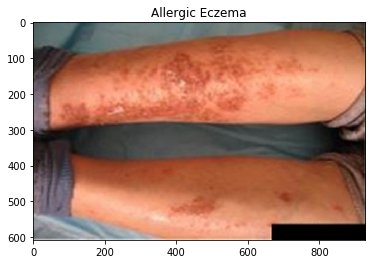

In [6]:
plt.title('Allergic Eczema')
plt.imshow(data_AllergicEczema[0])

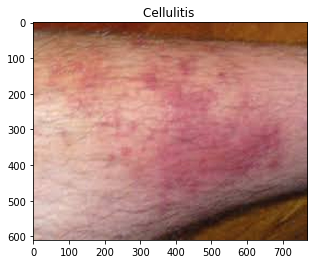

In [7]:
plt.title('Cellulitis ')
plt.imshow(data_Cellulitis[10])

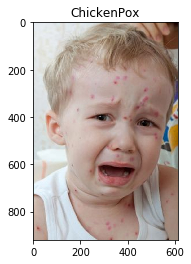

In [8]:
plt.title('ChickenPox')
plt.imshow(data_ChickenPox[0])

In [9]:
image_height = 299
image_width = 299
n_channels = 3
image_input = Input(shape=(image_height, image_width, 3))

In [10]:
## resizing entire image into same dimension and adding a label column:
## 0 - AllergicEczema
## 1 - ChickenPox
## 2 - Cellulitis

def resize_and_Label_Image(data_image, label):
    resized_labeled_image = []
    for img in tqdm(data_image):
        resized_labeled_image.append([cv2.resize(img, (image_height,image_width)), label])
    return resized_labeled_image

data_resized_AllergicEczema = resize_and_Label_Image(data_AllergicEczema, 0)
data_resized_ChickenPox = resize_and_Label_Image(data_ChickenPox, 1)
data_resized_Cellulitis = resize_and_Label_Image(data_Cellulitis, 2)

100%|██████████| 145/145 [00:00<00:00, 798.31it/s]


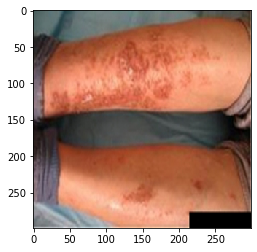

In [11]:
plt.imshow(data_resized_AllergicEczema[0][0])

In [12]:
print("#####ABOUT DATA######\n")
print("Images under Allergic Eczema")
print("Total Data: ", len(data_resized_AllergicEczema))
print("Shape: ", data_resized_AllergicEczema[0][0].shape)
print('\n')
print("Images under Chicken Pox")
print("Total Data: ", len(data_resized_ChickenPox))
print("Shape: ", data_resized_ChickenPox[0][0].shape)
print('\n')
print("Images under Cellulitis")
print("Total Data: ", len(data_resized_Cellulitis))
print("Shape: ", data_resized_Cellulitis[0][0].shape)

#####ABOUT DATA######

Images under Allergic Eczema
Total Data:  273
Shape:  (299, 299, 3)


Images under Chicken Pox
Total Data:  141
Shape:  (299, 299, 3)


Images under Cellulitis
Total Data:  145
Shape:  (299, 299, 3)


In [0]:
## append all images into one list and then shuffle the images
data_images = data_resized_AllergicEczema + data_resized_ChickenPox + data_resized_Cellulitis
random.shuffle(data_images)

In [14]:
len(data_images)

559

In [0]:
## After shuffle - will separate features and labels
X = []
y = []

for feature, label in data_images:
    X.append(feature)
    y.append(label)

In [16]:
print("images & labels sizes: ", (len(X), len(y)))

images & labels sizes:  (559, 559)


In [0]:
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2, stratify=y)

In [18]:
## one hot encoding for y_labels for train data

y_train_oneHotEncoding = to_categorical(train_y)
print('Train_data Shape: ', y_train_oneHotEncoding.shape)

## one hot encoding for y_labels for test data

y_test_oneHotEncoding = to_categorical(test_y)
print('Test_data Shape: ', y_test_oneHotEncoding.shape)

Train_data Shape:  (447, 3)
Test_data Shape:  (112, 3)


In [0]:
## array reshape and normalizing
train_X = np.array(train_X)
train_X = train_X/255
test_X = np.array(test_X)
test_X = test_X/255

## InceptionV3 Model as base model

In [20]:
## using imagenet weights and use VGG16 as base model

base_model=InceptionV3(weights='imagenet',include_top=False, input_shape=(image_height, image_width, n_channels)) # excluding the top fully connected layers
base_model.summary()












Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________

In [21]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


In [22]:
len(model.layers)

3

In [0]:
base_model.trainable = False

In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#history=model.fit(train_X,y_train_oneHotEncoding,batch_size=128,epochs=20,validation_split=0.2)

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

In [26]:
epochs = 30

train_generator = train_datagen.flow(train_X, y_train_oneHotEncoding, batch_size=32)
validation_generator = train_datagen.flow(train_X, y_train_oneHotEncoding, batch_size=16)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_X) / 32,
    epochs=epochs,
    validation_data=validation_generator
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
14/13 [==============================] - 282s 20s/step - loss: 1.1100 - acc: 0.4543 - val_loss: 1.1820 - val_acc: 0.3870
Epoch 2/30
14/13 [==============================] - 270s 19s/step - loss: 0.9246 - acc: 0.5371 - val_loss: 0.9549 - val_acc: 0.5369
Epoch 3/30
14/13 [==============================] - 270s 19s/step - loss: 0.8412 - acc: 0.6311 - val_loss: 0.9319 - val_acc: 0.5906
Epoch 4/30
14/13 [==============================] - 268s 19s/step - loss: 0.7733 - acc: 0.6511 - val_loss: 0.8974 - val_acc: 0.5928
Epoch 5/30
14/13 [==============================] - 267s 19s/step - loss: 0.7384 - acc: 0.6647 - val_loss: 0.9716 - val_acc: 0.5772
Epoch 6/30
14/13 [==============================] - 267s 19s/step - loss: 0.6902 - acc: 0.7359 - val_loss: 0.9309 - val_acc: 0.5884
Epoch 7/30
14/13 [==============================] - 266s 19s/step - loss: 0.6795 - acc: 0.7246 - val_loss: 0.943

In [27]:
test_loss,test_acc=model.evaluate(test_X,y_test_oneHotEncoding)
test_loss,test_acc

112/112 [==============================] - 33s 292ms/step


(0.9430369819913592, 0.6339285714285714)

In [0]:
prediction_prob = model.predict(test_X)
predicted_labels = prediction_prob.argmax(axis=-1)

In [29]:
confusion_matrix(test_y, predicted_labels)

array([[43, 11,  1],
       [ 6, 22,  0],
       [23,  0,  6]])

In [30]:
target_names = ['Allergic Eczema', 'Chicken Pox', 'Cellulitis']
print(classification_report(test_y, predicted_labels, target_names=target_names))

                 precision    recall  f1-score   support

Allergic Eczema       0.60      0.78      0.68        55
    Chicken Pox       0.67      0.79      0.72        28
     Cellulitis       0.86      0.21      0.33        29

       accuracy                           0.63       112
      macro avg       0.71      0.59      0.58       112
   weighted avg       0.68      0.63      0.60       112

